## Advances
User files a loan application1 (id)
The Bank approves the application on Date = underwritten_at 
The Bank send the (amount) to the user_id on Date = disbursed_at
One user can get many loans over time.
Total loan provided to a user, total_per_user = advances.groupby('user_id')['amount'].sum()

## Transactions
user_id performa a debit/credit transaction (id)


## Balances
Funds currently avaiable (available_balance) with the user_id as on Date= updated_at.
Current Balance includes pending transactions (not real money yet).
Available Balance is what they can actually spend. Always use the balance from before the loan decision. 
Use the last balance before the loan decision.

Simple Risk Rules:
Balance < $0 → High Risk
Balance between $0 and loan amount → Medium Risk
Balance > loan amount → Low Risk
Example (Loan = $25):
Balance -$10 → High Risk
Balance $0 → High Risk
Balance $15 → Medium Risk
Balance $50 → Low Risk
Balance $100 → Low Risk

## Labels
Links to each advance for a loan application (advance_id)
Was the amt fully repaid in 30 days? repaid_full_30d
% of amt rpaid in 30days = repaid_pct_30d
days_to_first_repay = it’s binary code.
How to Fix It:
Use Python to decode it. When you decode it, you get 3 numbers:
Position: 1st 2nd 3rd
Numbers: (0, 6, 28342991)
Ignore the 1st and 3rd numbers. The 2nd number is the number of days.
Real Example:
Raw data: b'\x00\x00\x00\x00\x06\x00\x00\x00\xcfz\xb0\x01'
After decoding: (0, 6, 28342991)
Days to first repay: 6 days 

If repaid_pct_30d >= 1.0 → repaid_full_30d = True (good)
If repaid_pct_30d < 1.0 → repaid_full_30d = False (bad)

## Application
Contains the app_id for all advances.

**Goal:** Predict 30-day repayment for FIRST-TIME borrowers only.

**IMPORTANT CRITERIA:**
- Only look at **first-time advances** (user's first loan ever)
- Predict: Will they pay back within 30 days?
- Measure: `repaid_full_30d` (True/False)

**The Process:**

**STEP 1: Start with one loan**
- Look at the ADVANCES table
- Pick one row = one loan to predict
- Example: User wants to borrow $25 on March 22

**STEP 1a: Check if this is their FIRST loan**
- Count how many loans this `user_id` has in ADVANCES table
- Filter: Only keep loans where this is the user's FIRST advance
- Skip this loan if they've borrowed before

**STEP 2: Find out what happened (30-day repayment) **
- Go to LABELS table
- Match: `labels.advance_id` = `advances.request_id`
- Look at: `repaid_full_30d` (True/False)
- This tells you: Did they pay back FULLY within 30 days?

**STEP 3: Find the person**
- Get the `user_id` from the advances table
- Now you know WHO borrowed the money

**STEP 4: Look at their spending history**
- Go to TRANSACTIONS table
- Find all rows with this `user_id`
- **IMPORTANT:** Only use transactions from BEFORE the loan date
- Count: How many times did they spend money?
- Calculate: What's their average spending?
- Look: What do they buy? (groceries, loan payments, etc.)

**STEP 5: Check their bank balance**
- Go to BALANCES table
- Find all rows with this `user_id`
- **IMPORTANT:** Only use balances from BEFORE the loan date
- Get the most recent balance
- Check: Is their balance positive or negative?
- See: Is their balance going up or down over time?

**STEP 6: Put it all together**
- Combine all the information for this one FIRST-TIME loan:
  - This is their first loan: Yes
  - Loan amount: $25
  - Their balance: $63
  - Number of transactions: 491
  - They pay other loans: Yes
  - Balance is positive: Yes

**STEP 7: Make a prediction**
- Predict: Will they pay back FULLY within 30 days?
- Then check `repaid_full_30d` in LABELS to see if you were right!

**STEP 8: Measure precision**
- For all first-time loans you predicted "Yes, they'll pay back":
  - Count how many actually paid back (True Positives)
  - Count how many did NOT pay back (False Positives)
  - Precision = True Positives / (True Positives + False Positives)

**Repeat for all FIRST-TIME loans in the dataset.**

In [1]:
# Read csv

import pandas as pd
import struct
import os

# Path to your folder
base_path = r"C:\Users\som\Desktop\CourseSem1\AlternativeData\Assignment\MiniProject\dataset_Final\Data"                             

# Load your CSVs
df_adv = pd.read_csv(os.path.join(base_path, "Advances.csv"))
df_app = pd.read_csv(os.path.join(base_path, "Applications.csv"))
df_bal = pd.read_csv(os.path.join(base_path, "Balances.csv"))
df_lab = pd.read_csv(os.path.join(base_path, "Labels.csv"))
df_txn = pd.read_csv(os.path.join(base_path, "Transactions.csv"))

#print(" Files loaded successfully")

**STEP 1: Start with one loan**
- Look at the ADVANCES table
- Pick one row = one loan to predict
- Example: User wants to borrow $25 on March 22

**STEP 1a: Check if this is their FIRST loan**
- Count how many loans this `user_id` has in ADVANCES table
- Filter: Only keep loans where this is the user's FIRST advance
- Skip this loan if they've borrowed before

**STEP 2: Find out what happened (30-day repayment) **
- Go to LABELS table
- Match: `labels.advance_id` = `advances.request_id`
- Look at: `repaid_full_30d` (True/False)
- This tells you: Did they pay back FULLY within 30 days?

In [2]:
# ADVANCES

# ensure underwritten_at is a datetime type
df_adv['underwritten_at'] = pd.to_datetime(df_adv['underwritten_at'])

# get first entry per user based on underwritten_at
first_entries = df_adv.sort_values('underwritten_at').drop_duplicates('user_id', keep='first')
# first_entries.to_csv('cleaned_advances.csv', index=False)

# create column for total loan amount per user
first_entries['total_per_user'] = df_adv.groupby('user_id')['amount'].transform('sum')
#print (first_entries.head())
print(first_entries.shape)
# Verify the results
#print(f"Original dataframe: {len(df_adv)} rows")
#print(f"First entries dataframe: {len(first_entries)} rows")
#print(f"Unique users in original: {df_adv['user_id'].nunique()}")
#print(f"Users in first entries: {len(first_entries)}")

# LABELS

# Decode binary column if present
def decode_days(val):
    if pd.isna(val):
        return None
    try:
        if isinstance(val, str) and val.startswith("b'"):
            val = eval(val)
        nums = struct.unpack("<III", val)
        return nums[1]  # take 2nd number
    except Exception:
        return None

if "days_to_first_repay" in df_lab.columns:
    df_lab["days_to_first_repay_decoded"] = df_lab["days_to_first_repay"].apply(decode_days)

# Create User Profile column based on conditions If repaid_pct_30d >= 1.0 → repaid_full_30d = True (good) If repaid_pct_30d < 1.0 → repaid_full_30d = False (bad)
df_lab.loc[
    (df_lab['repaid_pct_30d'] >= 1.0) & (df_lab['repaid_full_30d'] == True),
    'Usr_Profile'
] = 'good'

df_lab.loc[
    (df_lab['repaid_pct_30d'] < 1.0) | (df_lab['repaid_full_30d'] == False),
    'Usr_Profile'
] = 'bad'
print(df_lab.shape)

# Merge Labels & Advances based on advance_id
# Q: Did they pay back FULLY within 30 days?
merged = first_entries.merge(
    df_lab,
    left_on="request_id",   # from Advances.csv
    right_on="advance_id",  # from Labels.csv
    how="left",
    suffixes=("", "_label")
)

print(merged.shape)
#print(merged['advance_id'].isna().sum())
#df_lab['Usr_Profile'].value_counts()

(16691, 6)
(54616, 6)
(16691, 12)


**STEP 3: Find the person**
- Get the `user_id` from the advances table
- Now you know WHO borrowed the money
**STEP 4: Look at their spending history**
- Go to TRANSACTIONS table
- Find all rows with this `user_id`
- **IMPORTANT:** Only use transactions from BEFORE the loan date

In [3]:
print("df_txn columns:", df_txn.columns.tolist())
print(df_txn.head(3))

df_txn columns: ['id', 'user_id', 'date', 'authorized_date', 'created_at', 'primary_category', 'detailed_category', 'amount', 'merchant_name', 'name', 'original_description']
                                            id  \
0    b'\x13C\\Q:\xf2H7\xafi\x04\xe2\x058\xa1N'   
1  b'lm{i%OB\x16\x8e\xa9\x90\x86\x9cA\xde\x13'   
2  b'\x1cy\x8bT\xc1]E>\xaco\xdd\x029\xff\x19<'   

                                             user_id        date  \
0  b'\xf4.\x83\xfc\t\x1dO\xde\x8aG\xde\x12\xf9\x8...  2025-07-04   
1       b'\xce\xcbvY\xaaaF\xbd\xac=\x15"\t\xf9Q\x7f'  2025-06-12   
2     b'J\xba|:Y\x9dD\xe4\x92G\x0b\xe4C\xa2\xbf\xa2'  2025-07-07   

  authorized_date                  created_at primary_category  \
0      2025-07-04  2025-07-05 19:30:24.269317    ENTERTAINMENT   
1      2025-06-12  2025-07-07 04:37:56.929411   TRANSPORTATION   
2      2025-07-03  2025-07-08 11:04:30.245787   FOOD_AND_DRINK   

                      detailed_category  amount merchant_name  \
0    ENTERTAINMENT_CA

In [14]:
# MERGE Advances, Labels with Transactions 
adv_lab_txn = df_txn.merge(
    merged[['request_id', 'advance_id', 'user_id', 'underwritten_at', 
             'amount', 'repaid_full_30d', 'repaid_pct_30d', 'Usr_Profile']],
    on='user_id',
    how='left'
)
txn_date_col = 'date'

# then filter
adv_lab_txn = adv_lab_txn[adv_lab_txn[txn_date_col] < adv_lab_txn['underwritten_at']].copy()
# Filter to only include transactions BEFORE underwriting
adv_lab_txn = adv_lab_txn[adv_lab_txn[txn_date_col] < adv_lab_txn['underwritten_at']].copy()

# Final combined DataFrame
#print("Combined shape:", adv_lab_txn.shape)
print(adv_lab_txn.head(5))

                                                   id  \
4      b'\xc62\x00Q\xea\x88BS\xa2\xc661\xea\xc6u\xdb'   
16  b"'A\x94\xd7\x9bVA\\\x90\xd9\x0c\xb5\xe5\x16\x...   
17                 b'X\x0fw/EgJ\xfc\x9f\xa5\xffg93ra'   
61  b'\xf7\x86\x01t\xed\x88@v\xa8\xd6e\xdb\xf6\x88...   
63  b'\x10\xd23X\xf1\x90I\xa2\x8d[\xfa\x8f\x15\x01...   

                                              user_id       date  \
4   b'@\xf4\xe6\x0f\xa0\x89G*\x8b_\x92\xa1\x11c;\x80' 2025-01-27   
16  b'\x00\xc0\x13\xf8\xfa%O\x96\x99\x1b\x1cHl\xf4... 2025-04-10   
17  b'\x00\xc0\x13\xf8\xfa%O\x96\x99\x1b\x1cHl\xf4... 2025-02-21   
61    b"\xd1\xc7\\\x8e+>I'\xb9\x8b\x85\xbd\xb0\xcdzD" 2025-08-25   
63       b'B\xa4\x90F\x9f\x83G\xbb\xaej\x8f\r\xdeNxL' 2025-06-30   

   authorized_date                  created_at primary_category  \
4       2025-01-27  2025-03-04 00:15:24.820035     TRANSFER_OUT   
16             NaN  2025-04-28 00:32:13.633036   TRANSPORTATION   
17             NaN  2025-04-28 00:32:13.633036 

- Count: How many times did they spend money?
- Calculate: What's their average spending?
- Look: What do they buy? (groceries, loan payments, etc.)

In [15]:
# Creating Aggregate features

# ---------- 1) detect a transaction timestamp column ----------
candidates = ['date', 'authorized_date', 'created_at', 'posted_at', 'transaction_date', 'transacted_at']
txn_date_col = next((c for c in candidates if c in df_txn.columns), None)
if txn_date_col is None:
    raise KeyError(f"No transaction date column found in df_txn. Looked for: {candidates}. Please inspect df_txn.columns.")

# ---------- 2) ensure datetime types ----------
df_txn[txn_date_col] = pd.to_datetime(df_txn[txn_date_col], errors='coerce')
merged['underwritten_at'] = pd.to_datetime(merged['underwritten_at'], errors='coerce')

# ---------- 3) standardize id types to avoid mismatches ----------
df_txn['user_id'] = df_txn['user_id'].astype(str)
merged['user_id'] = merged['user_id'].astype(str)

# also ensure request_id / advance_id are strings for final merge keys
if 'request_id' in merged.columns:
    merged['request_id'] = merged['request_id'].astype(str)
if 'advance_id' in merged.columns:
    merged['advance_id'] = merged['advance_id'].astype(str)
if 'advance_id' in df_txn.columns:
    df_txn['advance_id'] = df_txn['advance_id'].astype(str)

# ---------- 4) optionally filter to spending transactions (positive = outflow in this dataset) ----------
spend_txn = df_txn[df_txn['amount'] > 0].copy()

# ---------- 5) merge transactions to advances on user_id (attach underwritten_at to each txn) ----------
adv_keys = merged[['request_id', 'user_id', 'underwritten_at']].drop_duplicates()
txn_with_advance = spend_txn.merge(adv_keys, on='user_id', how='left')

#print(txn_with_advance.head())

# ---------- 6) keep only transactions that occurred BEFORE the advance underwriting ----------
txn_before = txn_with_advance[txn_with_advance[txn_date_col] < txn_with_advance['underwritten_at']].copy()

# quick sanity prints
#print("txn_date_col used:", txn_date_col)
#print("Total transactions:", len(df_txn))
#print("Spending transactions:", len(spend_txn))
#print("Transactions matched to advances (after merge):", txn_with_advance['request_id'].notna().sum())
#print("Transactions before underwriting:", len(txn_before))

# ---------- 7) aggregate per advance (request_id) ----------
if len(txn_before) > 0:
    agg = txn_before.groupby('request_id', as_index=False).agg(
        txn_count_before = ('amount', 'size'),
        txn_total_before = ('amount', 'sum'),
        txn_avg_before   = ('amount', 'mean')
    )
else:
    # empty DataFrame with expected columns if no matching txns exist
    agg = pd.DataFrame(columns=['request_id', 'txn_count_before', 'txn_total_before', 'txn_avg_before'])

# ensure strings for merging
agg['request_id'] = agg['request_id'].astype(str)

# ---------- 8) merge agg back to merged (left join keeps all advances) ----------
# remove any existing columns that would conflict to avoid _x/_y proliferations:
for c in ['txn_count_before', 'txn_total_before', 'txn_avg_before']:
    if c in merged.columns:
        merged = merged.drop(columns=[c])

merged = merged.merge(agg, on='request_id', how='left')

# ---------- 9) fill NaNs (advances with no prior txns) ----------
merged['txn_count_before'] = merged['txn_count_before'].fillna(0).astype(int)
merged['txn_total_before'] = merged['txn_total_before'].fillna(0.0)
merged['txn_avg_before']   = merged['txn_avg_before'].fillna(0.0)

# ---------- 10) final checks ----------
#print("Shapes -> merged:", merged.shape, "agg:", agg.shape)
#print("Example aggregated columns preview:")
#print(merged[['request_id','user_id','underwritten_at','txn_count_before','txn_total_before','txn_avg_before']].head())

#DataFrame  represents a combined dataset that includes information from: Advances, Labels, Transactions
merged = merged.drop(columns=['txn_count_before_x', 'txn_total_before_x', 'txn_avg_before_x',
                              'txn_count_before_y', 'txn_total_before_y', 'txn_avg_before_y'], errors='ignore')
merged_alt = merged.copy()
#print(merge_alt.head)


In [16]:
# Verifying aggregate for one user
example_user = merged_alt.loc[merged_alt['txn_total_before'] > 0, 'user_id'].iloc[0]
print("Example user with spending > 0:", example_user)
merged_alt[merged_alt['user_id'] == example_user].T

Example user with spending > 0: b'\xb5\x1c\xca\xb5=\xefM\xf4\x99.I\x1a\xb9#k&'


,73
request_id,b'|\x1b\x0cYs\xcbL\xe8\x84\xbf;\x1eD\x1d(8'
underwritten_at,2024-08-28 13:16:17.361642
disbursed_at,2024-08-28 13:17:27.563381
amount,25.0
user_id,b'\xb5\x1c\xca\xb5=\xefM\xf4\x99.I\x1a\xb9#k&'
total_per_user,215.0
advance_id,b'|\x1b\x0cYs\xcbL\xe8\x84\xbf;\x1eD\x1d(8'
repaid_full_30d,True
repaid_pct_30d,1.0
days_to_first_repay,b'\x00\x00\x00\x00\x01\x00\x00\x00\xfa\x00t\x00'


Create Rules based on these aggregates 

**STEP 5: Check their bank balance**
- Go to BALANCES table
- Find all rows with this `user_id`
- **IMPORTANT:** Only use balances from BEFORE the loan date
- Get the most recent balance
- Check: Is their balance positive or negative?
- See: Is their balance going up or down over time?

Loan underwriting date: 2024-08-28 13:16:17.361642
Total balance records for this user: 1960
Balance records before underwriting: 120
Most recent balance record before underwriting:
user_id              b'\xb5\x1c\xca\xb5=\xefM\xf4\x99.I\x1a\xb9#k&'
updated_at                               2024-08-28 01:57:55.799839
available_balance                                              1.34
current_balance                                                1.34
Name: 4591481, dtype: object
Low balance (less than loan amount): Medium risk


<Axes: title={'center': "Balance Trend for User b'\\xb5\\x1c\\xca\\xb5=\\xefM\\xf4\\x99.I\\x1a\\xb9#k&'"}, xlabel='updated_at', ylabel='Available Balance ($)'>

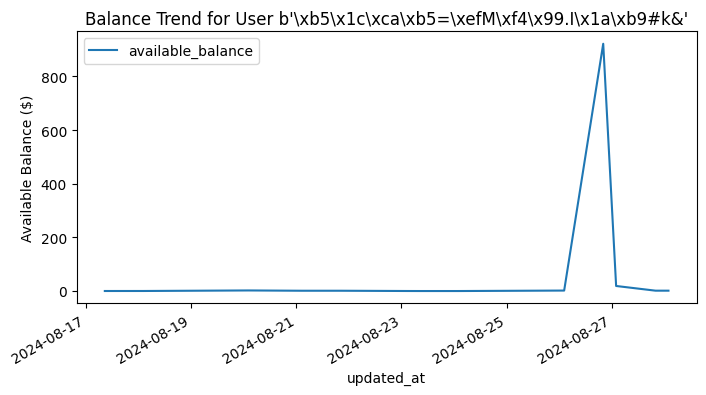

In [17]:
target_user = "b'\\xb5\\x1c\\xca\\xb5=\\xefM\\xf4\\x99.I\\x1a\\xb9#k&'"

#Get that user’s advance (loan) date
loan_date = merged_alt.loc[merged_alt['user_id'] == target_user, 'underwritten_at'].iloc[0]
print("Loan underwriting date:", loan_date)

#Filter the Balances table to this user
user_bal = df_bal[df_bal['user_id'] == target_user].copy()
print("Total balance records for this user:", len(user_bal))

#convert to datetime
candidates = ['updated_at', 'date', 'created_at', 'timestamp']
bal_date_col = next((c for c in candidates if c in user_bal.columns), None)
if bal_date_col is None:
    raise KeyError(f"No balance timestamp column found. Checked {candidates}.")

user_bal[bal_date_col] = pd.to_datetime(user_bal[bal_date_col], errors='coerce')

#Keeping balances before underwriting only
user_bal_before = user_bal[user_bal[bal_date_col] < loan_date].sort_values(bal_date_col)
print("Balance records before underwriting:", len(user_bal_before))

latest_bal = user_bal_before.iloc[-1]
print("Most recent balance record before underwriting:")
print(latest_bal)

bal_value = latest_bal['available_balance']
if bal_value < 0:
    print("Negative balance: High risk user")
elif bal_value < merged.loc[merged['user_id'] == target_user, 'amount'].iloc[0]:
    print("Low balance (less than loan amount): Medium risk")
else:
    print("Sufficient balance: Low risk")

user_bal_before[['available_balance', bal_date_col]].set_index(bal_date_col).plot(
    title=f"Balance Trend for User {target_user}",
    ylabel="Available Balance ($)",
    figsize=(8,4)
)

Now identifying Balances for all users and creating anew column 'Risk'

Risk rule :
Balance < 0 -> High
0 <= Balance < loan_amount -> Medium
Balance >= loan_amount -> Low

In [22]:
import pandas as pd
import numpy as np

# ensure datetimes and consistent ids 
df_bal['updated_at'] = pd.to_datetime(df_bal['updated_at'], errors='coerce')
merged['underwritten_at'] = pd.to_datetime(merged['underwritten_at'], errors='coerce')

# standardize user_id type to string to avoid mismatches
df_bal['user_id'] = df_bal['user_id'].astype(str)
merged['user_id'] = merged['user_id'].astype(str)

# also ensure request_id is string in merged (so results can join back reliably)
merged['request_id'] = merged['request_id'].astype(str)

# attach advance info to balances (so each balance row knows the advance date) 
adv_small = merged[['request_id', 'user_id', 'underwritten_at', 'amount']].drop_duplicates()
bal_with_adv = df_bal.merge(adv_small, on='user_id', how='left', suffixes=('', '_adv'))

# keep only balance snapshots that occurred BEFORE that advance's underwriting 
bal_before = bal_with_adv[bal_with_adv[bal_date_col] < bal_with_adv['underwritten_at']].copy()

# for each advance (request_id) pick the MOST RECENT balance (latest date) 
bal_before_sorted = bal_before.sort_values(['request_id', bal_date_col])
latest_bal_per_advance = bal_before_sorted.drop_duplicates(subset='request_id', keep='last').copy()
print("df_bal columns:", latest_bal_per_advance.columns.tolist())
# build the output columns and risk rule 
avail_col= 'available_balance'
bal_date_col= 'underwritten_at'

# rename chosen available balance column for clarity
latest_bal_per_advance = latest_bal_per_advance.rename(columns={avail_col: 'available_balance_before',
                                                                bal_date_col: 'balance_date_before'})

# Risk rule 
def assign_risk(row):
    bal = row['available_balance_before']
    loan_amt = row.get('amount', np.nan)
    if pd.isna(bal):
        return 'No Data'
    try:
        if bal < 0:
            return 'High'
        # If loan_amt missing, treat >= 0 as Medium
        if pd.isna(loan_amt):
            return 'Medium'
        if bal < loan_amt:
            return 'Medium'
        return 'Low'
    except Exception:
        return 'No Data'

latest_bal_per_advance['Risk'] = latest_bal_per_advance.apply(assign_risk, axis=1)

# Create final DataFrame 
new_df = latest_bal_per_advance[[
    'user_id',
    'request_id',
    'available_balance_before',
    'balance_date_before',
    'amount',
    'Risk'
]].rename(columns={'amount': 'loan_amount'})


new_df = new_df.reset_index(drop=True)

#  Quick summaries 
print("Records with a pre-loan balance found:", new_df['available_balance_before'].notna().sum())
print("Records with no pre-loan balance:", new_df['available_balance_before'].isna().sum())
print(new_df.head())

df_bal columns: ['user_id', 'updated_at', 'available_balance', 'current_balance', 'request_id', 'underwritten_at', 'amount']
Records with a pre-loan balance found: 14032
Records with no pre-loan balance: 459
                                             user_id  \
0    b'\xcd\x82\x0e7O\xefO~\x95c\x1d\xd3\x0c9\t\xb8'   
1  b'H7\x91\xc7\xd4\x81B\x92\xb9\xa4\x01\x8e\x12\...   
2     b'\xea\x92\xdc:\xed\x9dI\xc2\xa3j\xaa\xcaGsNq'   
3                      b'Ec\x86 GPF\r\x94\xbcC>{Vb:'   
4    b'~\x8d\xbeqd\x9dK\xef\xae\xe2P\xdf>\xac\x10\\'   

                                       request_id  available_balance_before  \
0        b" K9\xdd3\xaaDM\x9e\xedV'\xe3\x8f[\xd0"                      0.71   
1          b" \x11Y\xa3t}C\n\xb9\xc02a'\xd0\x1d~"                    259.07   
2                 b"!-\x98ZBML:\xb8_\x0c\x80('uA"                     27.39   
3        b"#\x99'Hv\x85F>\xaeei\xe8\xba\xdb\xa87"                      0.06   
4  b"#\xd8\x99[\x8a'I\xfe\x8c\x84m\x83\x16~B\xab"           

Combine all the information for this one FIRST-TIME loan: 
- This is their first loan: Yes 
- Loan amount: $25 
- Their balance: $63 
- Number of transactions: 491 
- They pay other loans: Yes 
- Balance is positive: Yes

In [23]:
# Merge the key data from new_df and merged_alt into one summary DataFrame
summary_df = (
    new_df[['user_id', 'loan_amount', 'available_balance_before','Risk']]
    .merge(
        merged_alt[['user_id', 'Usr_Profile', 'txn_total_before', 'txn_count_before']],
        on='user_id',
        how='left'
    )
)

# Add 'is_first_loan' (assuming all are first-time loans)
summary_df['is_first_loan'] = 'Yes'

# Add derived flag for positive balance
summary_df['balance_positive'] = summary_df['available_balance_before'].apply(
    lambda x: 'Yes' if pd.notna(x) and x > 0 else 'No'
)

# Reorder columns for clarity
summary_df = summary_df[
    [
        'user_id', 'is_first_loan', 'loan_amount', 'available_balance_before',
        'balance_positive', 'txn_count_before', 'txn_total_before',
        'Risk', 'Usr_Profile'
    ]
]

# Preview
print("Summary DataFrame shape:", summary_df.shape)
print(summary_df.head())

summary_df.to_csv('summary_df.csv', index=False)

Summary DataFrame shape: (14491, 9)
                                             user_id is_first_loan  \
0    b'\xcd\x82\x0e7O\xefO~\x95c\x1d\xd3\x0c9\t\xb8'           Yes   
1  b'H7\x91\xc7\xd4\x81B\x92\xb9\xa4\x01\x8e\x12\...           Yes   
2     b'\xea\x92\xdc:\xed\x9dI\xc2\xa3j\xaa\xcaGsNq'           Yes   
3                      b'Ec\x86 GPF\r\x94\xbcC>{Vb:'           Yes   
4    b'~\x8d\xbeqd\x9dK\xef\xae\xe2P\xdf>\xac\x10\\'           Yes   

   loan_amount  available_balance_before balance_positive  txn_count_before  \
0         25.0                      0.71              Yes                 0   
1         25.0                    259.07              Yes                 0   
2         25.0                     27.39              Yes                 0   
3         25.0                      0.06              Yes                 0   
4         25.0                      2.83              Yes                 0   

   txn_total_before    Risk Usr_Profile  
0               0.0  Mediu